In [311]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

champtoi = {}
itochamp = {}
annotation_path = '../greenscreends/train/_annotations.coco.json'
with open(annotation_path, 'r') as f:
    data = json.load(f)

for i, category in enumerate(data['categories']):
    champtoi[category['name']] = i
    itochamp[i] = category['name']

print(champtoi)
print(itochamp)

{'champions': 0, 'Aatrox': 1, 'Ability': 2, 'Ahri': 3, 'Akali': 4, 'Akshan': 5, 'Alistar': 6, 'Ambessa': 7, 'Amumu': 8, 'Anivia': 9, 'Annie': 10, 'Aphelios': 11, 'Ashe': 12, 'AurelionSol': 13, 'Aurora': 14, 'Azir': 15, 'Bard': 16, 'Belveth': 17, 'Blitzcrank': 18, 'Blue Cannon': 19, 'Blue Caster': 20, 'Blue Melee': 21, 'Blue Siege': 22, 'Brand': 23, 'Braum': 24, 'Briar': 25, 'Caitlyn': 26, 'Camille': 27, 'Cassiopeia': 28, 'Chogath': 29, 'Corki': 30, 'Darius': 31, 'Diana': 32, 'DrMundo': 33, 'Draven': 34, 'Ekko': 35, 'Elise': 36, 'Evelynn': 37, 'Ezreal': 38, 'Fiddlesticks': 39, 'Fiora': 40, 'Fizz': 41, 'Galio': 42, 'Gangplank': 43, 'Garen': 44, 'Gnar': 45, 'Gragas': 46, 'Graves': 47, 'Gwen': 48, 'Hecarim': 49, 'Heimerdinger': 50, 'Hwei': 51, 'Illaoi': 52, 'Irelia': 53, 'Ivern': 54, 'Janna': 55, 'JarvanIV': 56, 'Jax': 57, 'Jayce': 58, 'Jhin': 59, 'Jinx': 60, 'KSante': 61, 'Kaisa': 62, 'Kalista': 63, 'Karma': 64, 'Karthus': 65, 'Kassadin': 66, 'Katarina': 67, 'Kayle': 68, 'Kayn': 69, 'Kenn

In [312]:
import xml.etree.ElementTree as ET

def parse_pascal_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(champtoi[name])  

    return boxes, labels

def parse_coco_json(img_name, json_path):
    import json
    with open(json_path, 'r') as f:
        data = json.load(f)

    boxes = []
    labels = []

    for image in data['images']:
        if image['file_name'] == img_name:
            image_id = image['id']
            break
    
    for annotation in data['annotations']:
        if annotation['image_id'] == image_id:
            bbox = annotation['bbox']
            boxes.append(bbox)
            labels.append(annotation['category_id'])

    return boxes, labels

In [313]:
NUM_IMAGES = 10

In [369]:
import os
import random

random.seed(42)

img_boxes = os.listdir("/Users/HP/Documents/GitHub/JusticeGarenteed/greenscreends/train/")

imgs = sorted([img for img in img_boxes if img.endswith(".jpg")])

indices = random.sample(range(len(imgs)), NUM_IMAGES)
sampled_imgs = ['../greenscreends/train/' + imgs[i] for i in indices]

In [315]:
def plot_image_with_boxes(img, boxes, labels):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10), dpi = 300)
    plt.imshow(img_rgb)
    
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=1))
        plt.text(xmin, ymin -25, str(itochamp[label]), color='red', fontsize=7)

    plt.axis('off')
    plt.show()

In [316]:
def alpha_from_green_distance(img, strength = 0.9):
    """
    Estimate alpha based on how different the pixel is from green.
    
    :param strength: How much to amplify the difference from green.
        Higher strengths amplify difference between green and other colors.
        Lower the strength to make the alpha mask more forgiving (more of the original background remains/shows through the subject)
    :return: Alpha mask where green is 0 and other colors are 1.
    """

    img = img.astype(np.float32) / 255.0
    green = np.array([0, 1, 0], dtype=np.float32)
    diff = np.linalg.norm(img - green, axis=2)
    alpha_mask = np.clip(diff * strength, 0, 1)
    return alpha_mask

def despill(img, alpha, strength=0.75):
    """
    Reduce green from semi-transparent regions.
    
    :param float strength: How much to reduce green in the image.
        Higher values reduce more green, but may affect other colors.
        Lower values preserve more of the original image.
    """
    img = img.astype(np.float32) / 255.0
    alpha_exp = np.expand_dims(alpha, axis=-1)
    
    # Desaturate green where alpha is low
    green_reduction = (1 - alpha_exp[..., 0]) * strength
    img[..., 1] -= green_reduction
    img = np.clip(img, 0, 1)
    return img

def flatten_alpha_and_erase_green(rgba, erase_threshold=0.25):
    rgb = rgba[..., :3].astype(np.float32) / 255.0
    alpha = rgba[..., 3:] / 255.0

    # Zero out pixels where alpha is too low (erases green haze)
    mask = alpha > erase_threshold
    rgb = rgb * mask  # remove RGB where alpha is approx 0

    result = (rgb * 255).astype(np.uint8)
    return result

def chroma_key_preserve_glow(img_bgr, mask_col = [0,0,0]):
    img = img_bgr.copy()
    alpha = alpha_from_green_distance(img)
    alpha = cv2.GaussianBlur(alpha, (5, 5), 0)  # Feather for smoother transitions
    img_despilled = despill(img, alpha)

    rgba = np.dstack([img_despilled, alpha])
    rgba = (rgba * 255).astype(np.uint8)
    flattened = flatten_alpha_and_erase_green(rgba)
    # Mask out mask_col areas
    mask = np.all(flattened[..., :3] <= mask_col, axis=-1)
    flattened[mask] = [255, 255, 255]  # Set mask_col areas to white
    return flattened 


def clean_background_artifacts(img_bgr, green_bgr=(0, 255, 0), threshold=45):
    img = img_bgr.astype(np.float32)
    green = np.array(green_bgr, dtype=np.float32)

    # Compute distance from green color
    diff = np.linalg.norm(img - green, axis=2)

    # Create mask: preserve areas that differ enough from green
    mask_keep = (diff > threshold).astype(np.uint8)

    # Morphological open to clean up specks
    kernel = np.ones((3, 3), np.uint8)
    mask_keep = cv2.morphologyEx(mask_keep, cv2.MORPH_OPEN, kernel)

    # Replace non-kept regions with solid green
    cleaned = img.copy()
    cleaned[mask_keep == 0] = green

    return cleaned.astype(np.uint8)

def suppress_green_hue(rgb_img, hue_range=(40, 110), sat_thresh=60, val_thresh=50, shift_hue_by=0, desat_factor=0.95):
    """
    Suppress lime green hues remaining in the RGB image by shifting hue away from green.
    - hue_range: HSV hue range to treat as green (in degrees: 0–180 for OpenCV)
    - sat_thresh: minimum saturation to consider (to skip gray/white)
    - val_thresh: minimum value to consider (to skip very dark areas)
    - shift_hue_by: how much to shift hue away from green (e.g. +20)
    """
    img_hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

    H, S, V = img_hsv[..., 0], img_hsv[..., 1], img_hsv[..., 2]
    green_mask = (
        (H >= hue_range[0]) & (H <= hue_range[1]) &
        (S >= sat_thresh) & (V >= val_thresh)
    )

    # Shift hue for green pixels away from green (wrap around if needed)
    img_hsv[..., 0][green_mask] = (img_hsv[..., 0][green_mask] + shift_hue_by) % 180

    # Optionally, desaturate a bit
    img_hsv[..., 1][green_mask] = (img_hsv[..., 1][green_mask] * desat_factor).astype(np.uint8)

    result = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return result

def suppress_only_lime(rgb_img, hue_range=(60, 75), sat_thresh=80, val_thresh=60, desat_strength=0.3):
    """
    Suppress only pure lime green hues by desaturating them softly.
    No hue shift; preserves warm yellows and oranges.
    """
    img_hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV).astype(np.float32)

    H, S, V = img_hsv[..., 0], img_hsv[..., 1], img_hsv[..., 2]
    green_mask = (
        (H >= hue_range[0]) & (H <= hue_range[1]) &
        (S >= sat_thresh) & (V >= val_thresh)
    )

    # Desaturate only pure lime pixels slightly
    img_hsv[..., 1][green_mask] *= (1 - desat_strength)
    img_hsv = np.clip(img_hsv, 0, 255).astype(np.uint8)

    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

def context_aware_despill(rgb_img, alpha, green_thresh=0.28, blur_kernel=13, suppress_strength=0.5):
    """
    More aggressively remove green while preserving glow. No hue shifting.
    - Suppresses green using color distance AND alpha mask
    """
    rgb = rgb_img.astype(np.float32) / 255.0

    # Define green color in normalized RGB
    target_green = np.array([0.0, 1.0, 0.0])

    # Euclidean distance from pure green
    dist_from_green = np.linalg.norm(rgb - target_green, axis=2)
    green_mask = (dist_from_green < green_thresh) & (alpha > 0.15)

    # Generate blurred fallback image (local context)
    blurred_rgb = cv2.blur(rgb, (blur_kernel, blur_kernel))

    # Adaptive desaturation toward local blurred average
    rgb_out = rgb.copy()
    for c in range(3):
        rgb_out[..., c][green_mask] = (
            (1 - suppress_strength) * rgb[..., c][green_mask] +
            suppress_strength * blurred_rgb[..., c][green_mask]
        )

    rgb_out = np.clip(rgb_out, 0, 1)
    return (rgb_out * 255).astype(np.uint8)


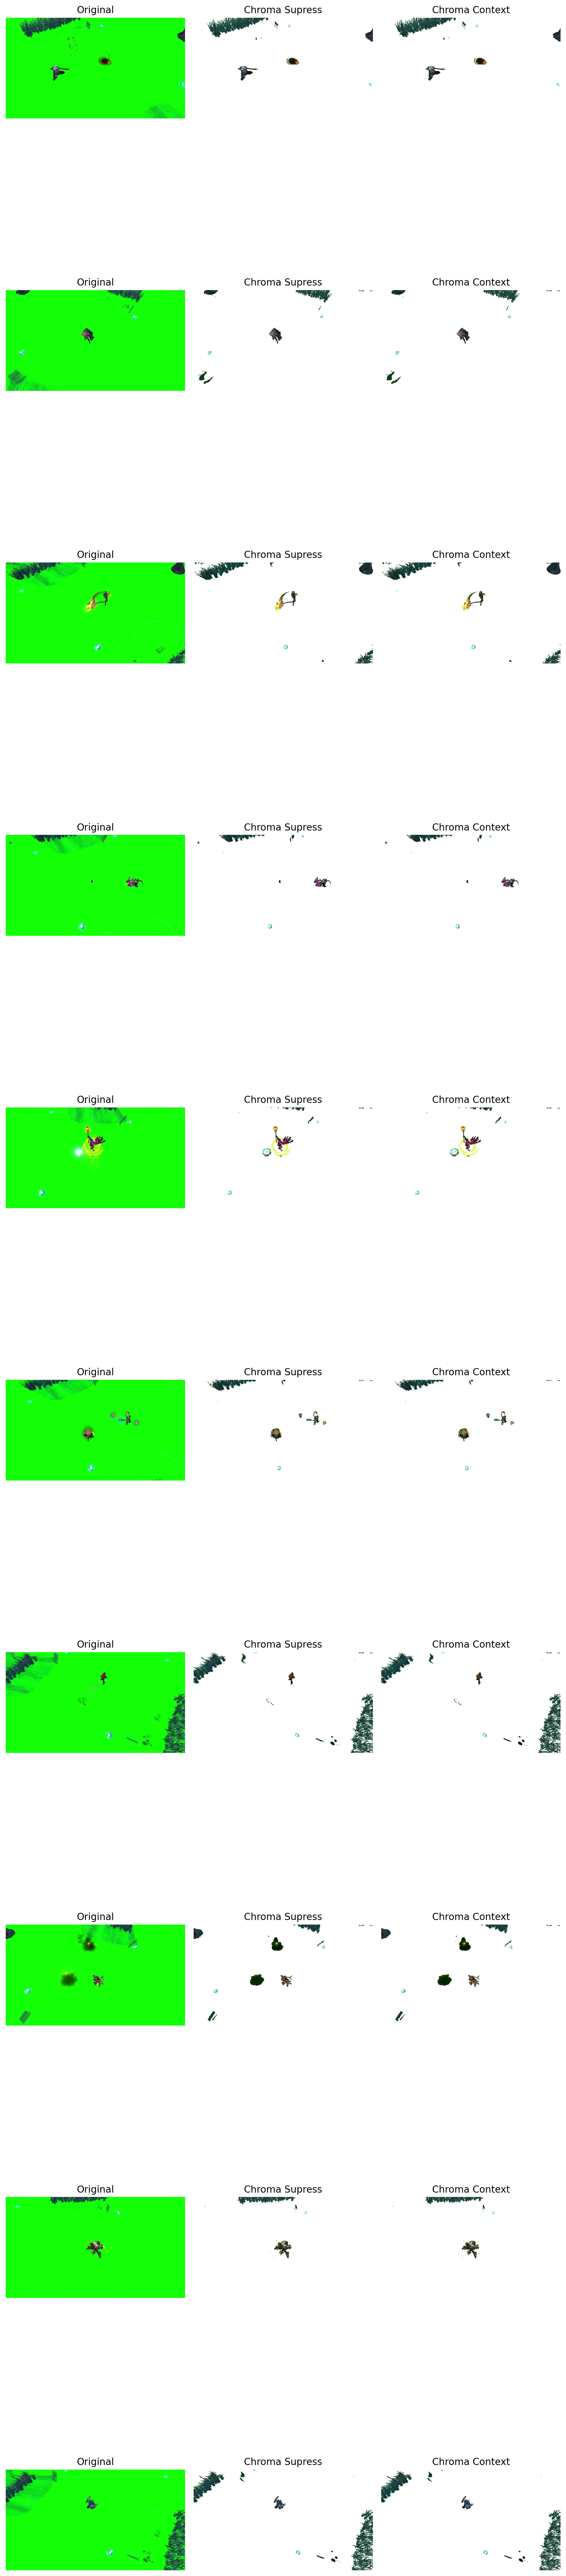

In [317]:
rows = len(sampled_imgs) 
 
fig, axes = plt.subplots(rows, ncols=3, figsize = (10, 5 * rows), dpi=200)
fig.subplots_adjust(hspace=0.01, wspace=0.1)

for i, img_path in enumerate(sampled_imgs):
    boxes, labels = parse_coco_json(os.path.basename(img_path), '../greenscreends/train/_annotations.coco.json')
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    axes[i][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i][0].axis('off')
    axes[i][0].set_title(f"Original")
    img_clean = clean_background_artifacts(img, green_bgr=(0, 255, 0), threshold=60)
    
    # masked = draw_matting(img_path)
    chroma = chroma_key_with_glow_preservation(img_clean)
    # chroma_suppress = suppress_only_lime(chroma, hue_range=(62, 73), sat_thresh=80, val_thresh=60, desat_strength=0.25)

    axes[i][1].imshow(cv2.cvtColor(chroma, cv2.COLOR_BGR2RGB))
    axes[i][1].axis('off')
    axes[i][1].set_title("Chroma Supress")
    
    alpha = alpha_from_green_distance(chroma)
    alpha = cv2.GaussianBlur(alpha, (5, 5), 0)  # soften transitions
    chroma_context = context_aware_despill(chroma, alpha=alpha)

    axes[i][2].imshow(cv2.cvtColor(chroma_context, cv2.COLOR_BGR2RGB))
    axes[i][2].axis('off')
    axes[i][2].set_title("Chroma Context")

plt.tight_layout()
plt.show()

### Champion/Ability Cutouts
- Assuming we have a working greenscreen cropping (which we don't but whatever)
- We use this algorithm to generate a cutout: 
- Get the bounding boxes of the champion and abilities used.
- Calculate IoU of champion with all ability bounding boxes
- Any ability box with IoU higher than 0.95 with champion is presumed to be for the champion itself and any lingering abilities - that will be used as the main champion cutout
    - Boundaries for that particular box can be determined by shrinking each side of the box until a non-white pixel is detected in a column/row
- Otherwise, the ability box is disjoint from the champion and can be placed anywhere UNLESS:
    - If any box is hugging the boundary of the image or close enough, it must be placed exactly on that part of the image, restricting where the cutout goes to that side of the image.



In [318]:
def generate_map_frames(video_path, dir_to_save, start_second, end_second, n = 5):
    """
    Generate frames from a video file and save them as images.
    
    :param video_path: Path to the input video file.
    :return: List of paths to the saved image frames.
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame = int(start_second * fps)
    end_frame = int(end_second * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    frame_count = 0
    saved_frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save every nth frame
        if start_frame + frame_count < end_frame:
            if frame_count % n == 0:
                frame_path = f"frame_{start_frame + frame_count}.jpg"
                cv2.imwrite(os.path.join(dir_to_save, frame_path), frame)
                saved_frames.append(frame_path)

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()

generate_map_frames('/Users/HP/Documents/GitHub/JusticeGarenteed/frames/fullmap.mp4', '../frames/map', 7.8, 8.4, n = 5)

In [326]:
def chroma_key_with_glow_preservation(
    img_bgr: np.ndarray,
    hsv_lower: int = 40,
    hsv_upper: int = 80,
    target_hue: int = 90,  # unused
    aggressive: bool = False,
    champ_boxes=None,
    pet_boxes=None,
    ability_boxes=None  # unused for now
) -> np.ndarray:
    if champ_boxes is None: champ_boxes = []
    if pet_boxes is None: pet_boxes = []

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)
    shape = h.shape

    region = np.zeros(shape, dtype=np.uint8)  # 0: normal, 1: champ, 2: pet

    for x_min, y_min, x_max, y_max in champ_boxes:
        region[y_min:y_max, x_min:x_max] = 1
    for x_min, y_min, x_max, y_max in pet_boxes:
        region[y_min:y_max, x_min:x_max] = 2

    normal = region == 0
    champ = region == 1
    pet = region == 2

    # Strong lime removal
    strong_mask = np.zeros(shape, dtype=bool)
    if aggressive:
        strong_mask |= (h >= hsv_lower) & (h <= hsv_upper) & (s >= 100) & (v >= 100) & normal
    else:
        strong_mask |= (h >= hsv_lower) & (h <= hsv_upper) & (s >= 150) & (v >= 150) & normal
    strong_mask |= (h >= hsv_lower) & (h <= hsv_upper) & (s >= 150) & (v >= 150) & champ
    strong_mask |= (h >= hsv_lower) & (h <= hsv_upper) & (s >= 170) & (v >= 170) & pet

    out = img_bgr.copy()
    out[strong_mask] = (255, 255, 255)

    # Hue proximity to lime
    proximity = 1.0 - (np.abs(h - (hsv_lower + hsv_upper) / 2) / ((hsv_upper - hsv_lower) / 2))
    proximity = np.clip(proximity, 0, 1)

    lime_band = (h >= hsv_lower) & (h <= hsv_upper)
    darken_mask = lime_band & ~strong_mask

    # Base darkening
    strength = proximity * 0.8

    # Pets: always mild
    strength[pet] *= 0.3

    # Champions: dynamic darkening (how green they are on avg)
    for x_min, y_min, x_max, y_max in champ_boxes:
        box_mask = np.zeros_like(region, dtype=bool)
        box_mask[y_min:y_max, x_min:x_max] = True

        # Compute average proximity inside box
        avg_prox = np.mean(proximity[box_mask])

        # More lime (avg_prox near 1) ➝ reduce darkening
        box_strength = (1.0 - avg_prox)  # if fully lime, near 0
        strength[box_mask] *= box_strength  # scale whole box by this

    # Apply darkening
    v[darken_mask] *= (1 - strength[darken_mask])

    hsv[..., 2] = v
    hsv = np.clip(hsv, 0, 255).astype(np.uint8)
    darkened = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    out[darken_mask] = darkened[darken_mask]

    return out

In [320]:
def simple_chroma_key(
    img_bgr: np.ndarray,
    threshold: float = 0.5,
    bg_color: tuple = (255, 255, 255)
) -> np.ndarray:
    """
    Very simple chroma key:
      - Compute per-pixel distance to pure green ([0,1,0]).
      - Pixels closer than `threshold` are background.
      - Paint them with `bg_color`.
    """
    img = img_bgr.astype(np.float32) / 255.0
    dist = np.linalg.norm(img - np.array([0, 1, 0], np.float32), axis=2)
    fg_mask = dist > threshold
    out = img_bgr.copy()
    out[~fg_mask] = bg_color
    return out


In [401]:
def IoU(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes. Assumes coco format
    
    :param box1: First bounding box in coco format [x_min, y_min, w, h]
    :param box2: Second bounding box in coco format [x_min, y_min, x_max, y_max].
    :return: IoU value.
    """

    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def check_box_in_box(box1, box2):
    """
    Check if box1 is inside box2.
    
    :param box1: First bounding box in PASCAL VOC format [x_min, y_min, x_max, y_max].
    :param box2: Second bounding box [x_min, y_min, x_max, y_max].
    :return: True if box1 is inside box2, False otherwise.
    """
    # get the coordinates of box1 in pascal VOC format
    return (box1[0] >= box2[0] and
            box1[1] >= box2[1] and
            box1[2] <= box2[2] and
            box1[3] <= box2[3])

def chroma_crop_out_white(img, box):
    """
   Crop the image using the bounding box, chroma key and then remove white areas.
    
    :param img: Input image.
    :return: Cropped image.
    """

    # shrink box to just hit edges (until there's no white)
    x_min, y_min, x_max, y_max = box

    cropped_img = img[y_min:int(y_max), x_min:int(x_max)]
    cropped_img = chroma_key_with_glow_preservation(cropped_img)
    mask = cv2.inRange(img, (0, 0, 0), (255, 255, 255))
    mask = cv2.bitwise_not(mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        # Update the bounding box
        x_min = x + x_min
        y_min = y + y_min
        x_max = x + x_min + w
        y_max = y + y_min + h
        box = [x_min, y_min, x_max, y_max]
        return cropped_img, box
    else:
        # No contours found, return the cropped image and box
        return cropped_img, box

def generate_cutout(img_path, annotation_path):
    """
    Generate a cutout image from the original image and its corresponding XML file.
    Returns cutout and a dictionary with bounding boxes for champion, pet, and ability in PASCAL VOC format.
    
    :param img_path: Path to the input image file.
    :param xml_path: Path to the corresponding XML file.
    :return: Cutout image with green screen removed.
    """
    img = cv2.imread(img_path)
    boxes, labels = parse_coco_json(os.path.basename(img_path), annotation_path)
    champion_box = None
    mask_box = None
    pet_boxes = []
    ability_boxes = set()
    label = 0

    box_dict = {'Ability' : [], 'Pet': [], 'Mask': []}

    for box, label in zip(boxes, labels):
        # Convert box to PASCAL VOC format [x_min, y_min, x_max, y_max]
        box = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
        if label != champtoi['Ability'] and label != champtoi['Pet']:
            champion_box = box
            champion_label = label
        elif label == champtoi['Ability']:
            ability_boxes.add(tuple(box))
        else:
            pet_boxes.append(box)
    
    box_dict[itochamp[champion_label]] = []
    print(champion_box)
    # Check if champion/pet box is inside ability box or significant overlap
    for box in ability_boxes:
        if check_box_in_box(champion_box, box) or IoU(champion_box, box) > 0.9:
            mask_box = box
            print(f"Mask box found: {mask_box}")    
        else:
            box_dict['Ability'].append(box)
    
    if mask_box is not None:
        ability_boxes.remove(mask_box)
        cutout, mask_box = chroma_crop_out_white(img, mask_box)  

    else: # If no mask box was found, we need to create one based on the champion box
        x_min, y_min, x_max, y_max = champion_box

        #Expand champion box by 85 percent
        x_min = max(0, int(x_min - (x_max - x_min) * 0.85))
        y_min = max(0, int(y_min - (y_max - y_min) * 0.85))
        x_max = min(img.shape[1], int(x_max + (x_max - x_min) * 0.85))
        y_max = min(img.shape[0], int(y_max + (y_max - y_min) * 0.85))
        mask_box = [x_min, y_min, x_max, y_max]
        box_dict['Mask'].append(mask_box)
        cutout, mask_box = chroma_crop_out_white(img, mask_box) 

    # Adjust champion box to be relative to the mask box            
    x_min, y_min, x_max, y_max = mask_box
    
    x_min_champ, y_min_champ, x_max_champ, y_max_champ = champion_box
    x_min_champ = max(0, int(x_min_champ - x_min))
    y_min_champ = max(0, int(y_min_champ - y_min))
    x_max_champ = min(cutout.shape[1], int(x_max_champ - x_min))
    y_max_champ = min(cutout.shape[0], int(y_max_champ - y_min))
    champion_box = [x_min_champ, y_min_champ, x_max_champ, y_max_champ]
    # Add the mask box to the box_dict
    box_dict["Mask"].append(list(mask_box))

    for pet_box in pet_boxes:
        if check_box_in_box(pet_box, mask_box) or IoU(pet_box, mask_box) > 0.9:
            x_min, y_min, x_max, y_max = mask_box

            x_min_pet, y_min_pet, x_max_pet, y_max_pet = pet_box
            
            x_min_pet = max(0, int(x_min_pet - x_min))
            y_min_pet = max(0, int(y_min_pet - y_min))
            x_max_pet = min(cutout.shape[1], int(x_max_pet - x_min))
            y_max_pet = min(cutout.shape[0], int(y_max_pet - y_min))
            box_dict['Pet'].append([x_min_pet, y_min_pet, x_max_pet, y_max_pet])
            
    box_dict[itochamp[champion_label]].append(champion_box)
    print(champion_box)
    return cutout, box_dict 

def place_cutout(map_img, cutout, box_dict, x, y):
    """
    Place the cutout image on the map image at the specified coordinates,
    only pasting non-white pixels (to preserve transparency-like behavior).
    If the original mask box/champion box hugs a side of the image, the cutout can only be placed along that side.
    Abilities can be placed anywhere (even cut off the map) but champions and pets must be placed within the map bounds

    :param map_img: The map image (HWC, RGB) where the cutout will be placed.
    :param cutout: The cutout image to be placed (HWC, RGB).
    :param box_dict: Dictionary containing bounding boxes for champion, pet, and ability.
    :param x: X-coordinate for placement (top-left).
    :param y: Y-coordinate for placement (top-left).
    :return: Map image with the cutout placed.
    """
    mask_x_min, mask_y_min, mask_x_max, mask_y_max = box_dict['Mask'][0]
    champ_name = ""
    for key in box_dict:
        if key != 'Mask' and key != 'Ability' and key != 'Pet':
            champ_name = key
            break

    champ_x_min, champ_y_min, champ_x_max, champ_y_max = box_dict[champ_name][0]
    # Check if cutout hugs side of image. If so, we can only place it along that side.
    if mask_x_min == 1 or champ_x_min == 1:
        x = 0
    if mask_y_min == 1 or champ_y_min == 1:
        y = 0
    if mask_x_max == map_img.shape[1] or champ_x_max == map_img.shape[1]:
        x = map_img.shape[1] - cutout.shape[1]
    if mask_y_max == map_img.shape[0] or champ_y_max == map_img.shape[0]:
        y = map_img.shape[0] - cutout.shape[0]

    # If placing the cutout makes the ability box go out of bounds, you can do so but up until the champion box hugging
    # the border of the image
    h, w = cutout.shape[:2]
    h = min(h, map_img.shape[0] - y)
    w = min(w, map_img.shape[1] - x)
    # Crop the region of interest from the map
    cutout = cutout[:h, :w]
    roi = map_img[y:y + h, x:x + w]

    # Create a mask for non-white pixels
    mask = ~(np.all(cutout == [255, 255, 255], axis=-1))

    # Broadcast mask to RGB
    mask_rgb = np.stack([mask]*3, axis=-1)    
    
    # Blend cutout into ROI using the mask
    roi[mask_rgb] = cutout[mask_rgb]

    # Put the modified ROI back
    map_img[y:y + h, x:x + w] = roi
    # Update the bounding boxes in box_dict to be relative to the map image
    new_pet_boxes = []
    for key in box_dict:
        if len(box_dict[key]):
            for box in box_dict[key]:
                x_min, y_min, x_max, y_max = box
                if key != 'Mask' and key != 'Ability':
                    # Just shift the champion/pet box
                    x_min = max(0, int(x_min + x))
                    y_min = max(0, int(y_min + y))
                    x_max = int(x_max + x)
                    y_max = int(y_max + y)
                    if x_max > map_img.shape[1] or y_max > map_img.shape[0]:
                        raise ValueError(f"Box {key} goes out of bounds: {box}")
                    if key == 'Pet':
                        new_pet_boxes.append([x_min, y_min, x_max, y_max])
                    else:
                        box_dict[key] = [x_min, y_min, x_max, y_max]
                    
                else: 
                    x_diff = box[0] - x
                    y_diff = box[1] - y
                    x_min = max(0, int(x_min - x_diff))
                    y_min = max(0, int(y_min - y_diff))
                    x_max = min(map_img.shape[1], int(x_max - x_diff))
                    y_max = min(map_img.shape[0], int(y_max - y_diff))
                    box_dict[key] = [x_min, y_min, x_max, y_max]
    if len(new_pet_boxes):
        box_dict['Pet'] = new_pet_boxes
    return map_img, box_dict

In [478]:
def count_non_white_pixels(img):
    """
    Count the number of non-white pixels in an image.
    
    :param img: Input image (HWC, RGB).
    :return: Number of non-white pixels.
    """
    # Define white color in RGB
    white = np.array([255, 255, 255], dtype=np.uint8)
    
    # Create a mask for non-white pixels
    non_white_mask = np.any(img != white, axis=-1)
    
    # Count non-white pixels
    return np.sum(non_white_mask)

def generate_cutouts(img_paths, annotation_path):
    """
    Generate cutouts for multiple images and their corresponding bounding boxes.
    
    :param img_paths: List of paths to the input image files.
    :param annotation_path: Path to the corresponding annotations file.
    :return: List of cutout images and their bounding boxes.
    """
    cutouts = []
    box_dicts = []
    
    for img_path in img_paths:
        cutout, box_dict = generate_cutout(img_path, annotation_path)
        cutouts.append(cutout)
        box_dicts.append(box_dict)

    cutouts_sorted, box_dicts_sorted = zip(*sorted(zip(cutouts, box_dicts), key=lambda x: count_non_white_pixels(x[0])))
    
    n = len(cutouts)
    plt.figure(figsize=(4 * n, 4))
    for i, cutout in enumerate(cutouts_sorted):
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(cutout, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Cutout {i+1}')
    plt.show()

    return cutouts_sorted, box_dicts_sorted

def place_cutouts_on_map(map_img, cutouts, box_dicts, positions):
    """
    Place multiple cutouts on the map image at specified positions.
    
    :param map_img: The map image (HWC, RGB) where the cutouts will be placed.
    :param cutouts: List of cutout images to be placed (HWC, RGB).
    :param box_dicts: List of dictionaries containing bounding boxes for each cutout.
    :param positions: List of tuples (x, y) for each cutout's placement.
    :return: Map image with all cutouts placed.
    """
    box_dict_all = {}
    for cutout, box_dict, pos in zip(cutouts, box_dicts, positions):
        x, y = pos
        map_img, box_dict = place_cutout(map_img, cutout, box_dict, x, y)
        for key in box_dict:
            if len(box_dict[key]):
                if key not in box_dict_all:
                    box_dict_all[key] = []
                box_dict_all[key].append(box_dict[key])
    
    return map_img, box_dict_all

In [452]:
def get_boxes_from_box_dict(box_dict):
    """
    Convert the box_dict to a list of boxes for each category.
    
    :param box_dict: Dictionary containing bounding boxes for champion, pet, and ability.
    :return: List of boxes for each category.
    """
    boxes = []
    labels = []
    for key in box_dict:
        if len(box_dict[key]):
           for box in box_dict[key]:
                if key == 'Pet':
                    for pet_box in box:
                        boxes.append(pet_box)
                        labels.append(champtoi['Pet'])
                elif key != 'Mask' and key != 'Ability':
                    labels.append(champtoi[key])
                    boxes.append(box)
                else:
                    labels.append(champtoi['Ability'])
                    boxes.append(box)
    return boxes, labels

In [ ]:
def convert_coco_to_pascal_voc(boxes):
    """
    Convert COCO format boxes to PASCAL VOC format.
    
    :param boxes: List of boxes in COCO format [x_min, y_min, width, height].
    :return: List of boxes in PASCAL VOC format [x_min, y_min, x_max, y_max].
    """
    pascal_boxes = []
    for box in boxes:
        x_min, y_min, width, height = box
        x_max = x_min + width
        y_max = y_min + height
        pascal_boxes.append([x_min, y_min, x_max, y_max])
    return pascal_boxes

[713, 194, 926.53, 422.91999999999996]
Mask box found: (672, 158, 1350.51, 574.25)
[41, 36, 254, 264]
[1011, 637, 1189.17, 796.69]
Mask box found: (762, 426, 1386, 1058.8200000000002)
[249, 211, 427, 370]
[638, 460, 812.52, 648.23]
Mask box found: (491, 323, 1374.95, 750.29)
[147, 137, 321, 325]


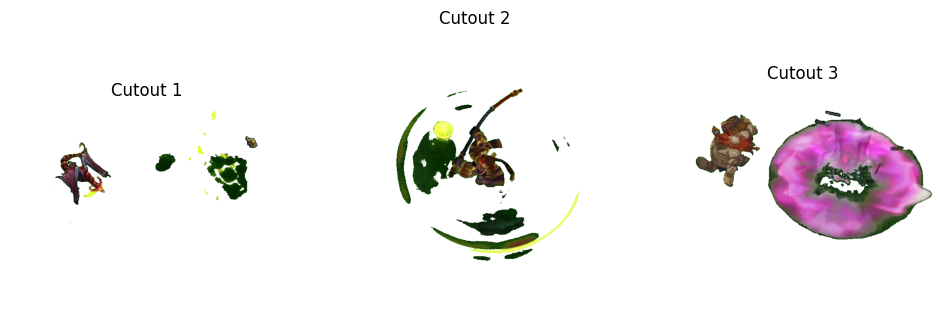

{'Mask': [[100, 100, 983, 527], [200, 200, 824, 832], [300, 300, 978, 716]], 'Shyvana': [[247, 237, 421, 425]], 'MonkeyKing': [[449, 411, 627, 570]], 'Gragas': [[341, 336, 554, 564]]}
[[247, 237, 421, 425], [449, 411, 627, 570], [341, 336, 554, 564]]


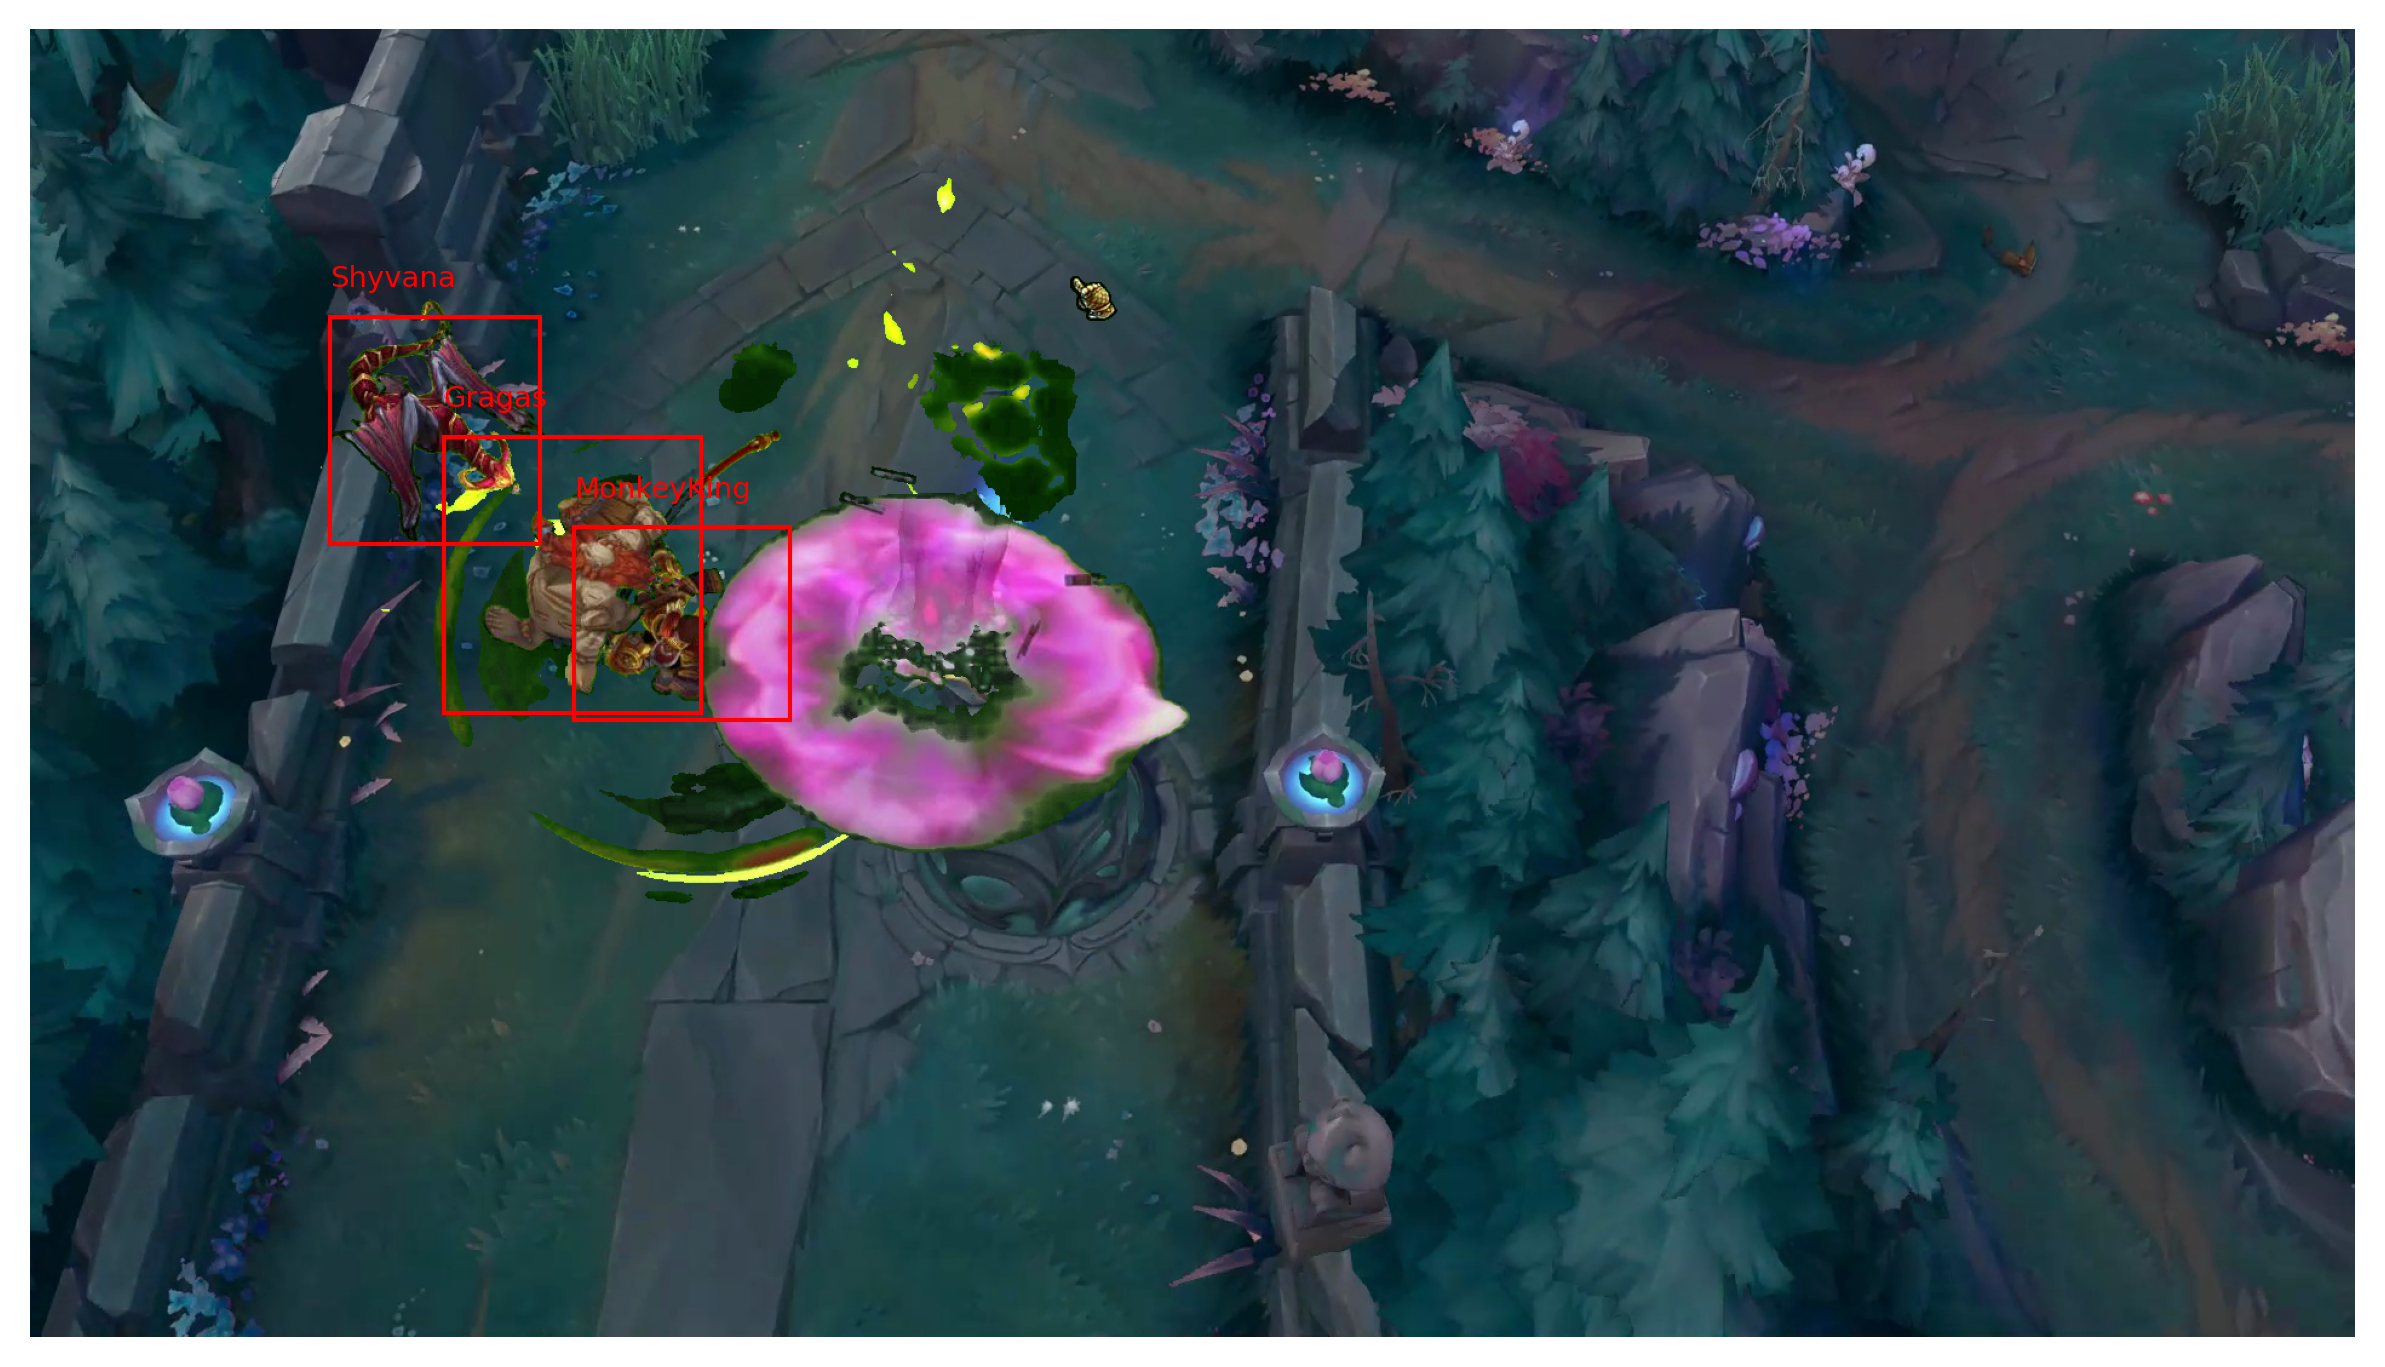

In [493]:
import random
imgs = os.listdir('../greenscreends/train/')
imgs = [img for img in imgs if img.endswith('.jpg')]
imgs = [os.path.join('../greenscreends/train/', img) for img in imgs]

test_imgs = random.sample(imgs, 3)
cutouts, box_dicts = generate_cutouts(test_imgs, annotation_path)

map_img = "../frames/map/map_frame_270.jpg"
map_img = cv2.imread(map_img)
map_img, box_dict_all = place_cutouts_on_map(map_img, cutouts, box_dicts, [(100, 100), (200, 200), (300, 300)])
print(box_dict_all)
del box_dict_all['Mask']  # Remove mask box from the final output
boxes, labels = get_boxes_from_box_dict(box_dict_all)
print(boxes)
plot_image_with_boxes(map_img, boxes, labels)